#Pneumonia Classification

In this notebook i create a classifier to predict whether an X-Ray of a patient shows signs of pneumonia or not based on the RSNA Pneumonia Detection Challenge (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge):

In this competition, you’re challenged to build an algorithm to detect a visual signal for pneumonia in medical images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.

Pneumonia accounts for over 15% of all deaths of children under 5 years old internationally. In 2015, 920,000 children under the age of 5 died from the disease. In the United States, pneumonia accounts for over 500,000 visits to emergency departments [1] and over 50,000 deaths in 2015 [2], keeping the ailment on the list of top 10 causes of death in the country.

## 1-Ignition

### 1.1- Set up Kernel and Required Dependencies

In [1]:
! pip install -q kaggle
! pip install pydicom==3.0.1
! pip install opencv-python==4.10.0.84
! pip install pytorch_lightning==2.4.0
! pip install torchmetrics==1.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 37.7 MB/s eta 0:00:00


## 1.2 - Loading Libs and Functions

In [2]:
import os, shutil
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from pydicom.filereader import dcmread
import cv2

import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [34]:
###Parameters:
download_folder="/content/drive/My Drive/Colab Notebooks/Pneumonia_Classification_data"
zip_file=os.path.join(download_folder, 'rsna-pneumonia-detection-challenge.zip')

colab_folder="/content/data"
colab_train_csv=os.path.join(colab_folder, 'stage_2_train_labels.csv')
colab_train_img=os.path.join(colab_folder, 'stage_2_train_images')
colab_processing=os.path.join(colab_folder, 'processing')
colab_weights=os.path.join(colab_folder, 'weights')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

files2Copy=["ml_funcs.py"]

# 2-Loading Data and Augmention

### 2.1 - Downloading Data and moving to Colab

In [27]:
# ### download kaggle data in Google Drive
# import zipfile
# from google.colab import drive
# from google.colab import files
# drive.mount('/content/drive/')

# files.upload()
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# if not os.path.exists(download_folder):
#   os.mkdir(download_folder)
# os.chdir(download_folder)
# ! kaggle competitions download -c rsna-pneumonia-detection-challenge

# archive = zipfile.ZipFile(zip_file)
# # ufiles=[file for file in archive.namelist() if not file.startswith(('train/', 'test/', 'tfrecords/'))]
# for file in tqdm(archive.namelist()):
#   archive.extract(file, download_folder)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


100%|██████████| 29688/29688 [07:10<00:00, 69.00it/s]


In [4]:
###copying from google Drive to Colab:
import shutil
from google.colab import drive
drive.mount('/content/drive/')

shutil.copytree(download_folder, colab_folder)
for file in files2Copy:
  shutil.copyfile(os.path.join('/content/drive/My Drive/Colab Notebooks/', file), os.path.join('/content', file))

labels = pd.read_csv(colab_train_csv)
labels = labels.drop_duplicates("patientId")

print(labels['Target'].value_counts())

Mounted at /content/drive/
Target
0    20672
1     6012
Name: count, dtype: int64


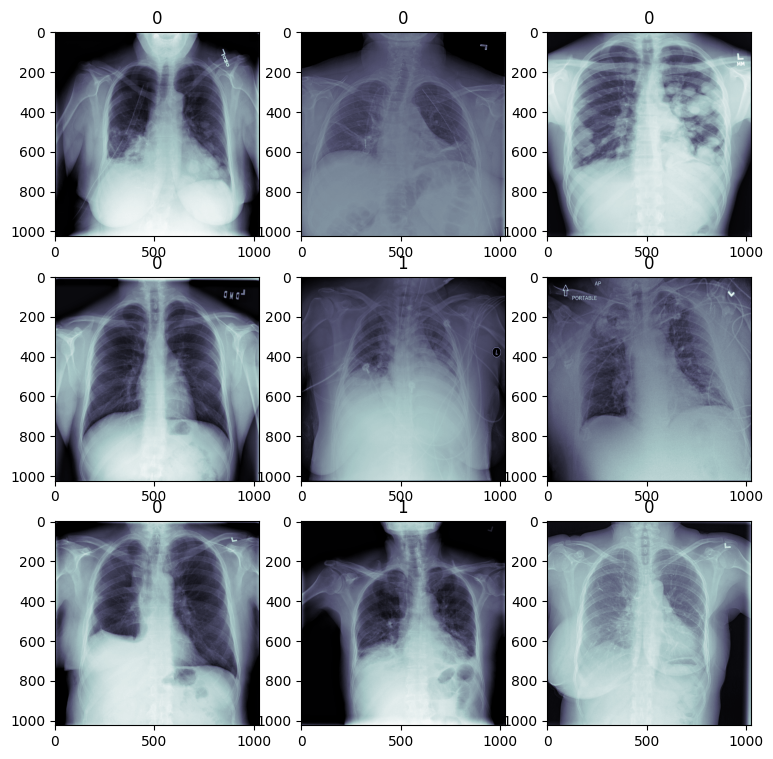

In [5]:
#some example images:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))
c = 0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        dcm_path = os.path.join(colab_train_img, f'{patient_id}.dcm')
        dcm = dcmread(dcm_path).pixel_array

        label = labels["Target"].iloc[c]

        axis[i][j].imshow(dcm, cmap="bone")
        axis[i][j].set_title(label)
        c+=1

### 2.2- Reading Dicom, Resizing and converting to numpy arrays

In [6]:
# directly save the standardized and resized files into the corresponding directory (0 for healthy, 1 for pneumonia).
# This allows to take advantage of the ready-to-use torchvision DatasetFolder for simple file reading
## TODO: do this step in googld drive and copy files to colab
sums = 0
sums_squared = 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
    dcm_path = os.path.join(colab_train_img, f'{patient_id}.dcm')

    # Read the dicom file with pydicom and standardize the array
    dcm = dcmread(dcm_path).pixel_array / 255
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)
    label = labels.Target.iloc[c]

    # 4/5 train split, 1/5 val split
    train_or_val = "train" if c < 24000 else "val"
    current_save_path=os.path.join(colab_processing, train_or_val, str(label))
    if not os.path.exists(current_save_path):
        os.makedirs(current_save_path)
    np.save(os.path.join(current_save_path,patient_id), dcm_array)

    normalizer = dcm_array.shape[0] * dcm_array.shape[1]
    if train_or_val == "train":
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (np.power(dcm_array, 2).sum()) / normalizer

mean = sums / 24000
std = np.sqrt(sums_squared / 24000 - (mean**2))
print(f"Mean of Dataset: {mean}, STD: {std}")

100%|██████████| 26684/26684 [03:56<00:00, 112.64it/s]

Mean of Dataset: 0.4903962485384803, STD: 0.24795070634161256


### 2.3-Normalization, Augmentation and Data Loader

In [8]:
##Data Augmentation:
# RandomResizedCrops which applies a random crop of the image and resizes it to the original image size (224x224)
# Random Rotations between -5 and 5 degrees
# Random Translation (max 5%)
# Random Scaling (0.9-1.1 of original image size)

mean, std= .490, .248

def load_file(path):
    return np.load(path).astype(np.float32)

train_transforms = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std),
                                    transforms.RandomAffine(
                                        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                        transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))
                                  ])

val_transforms = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.49], [0.248]),
                                  ])

train_dataset = torchvision.datasets.DatasetFolder(os.path.join(colab_processing, 'train'),
                                                  loader=load_file, extensions="npy", transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder(os.path.join(colab_processing,  'val'),
                                                  loader=load_file, extensions="npy", transform=val_transforms)

# some augmented train images
# fig, axis = plt.subplots(2, 2, figsize=(9, 9))
# for i in range(2):
#     for j in range(2):
#         random_index = np.random.randint(0, 20000)
#         x_ray, label = train_dataset[random_index]
#         axis[i][j].imshow(x_ray[0], cmap="bone")
#         axis[i][j].set_title(f"Label:{label}")

batch_size = 64
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 24000 train images and 2684 val images


# 3-Training

Model: **ResNet18**

In [32]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self, weight=1):
        super().__init__()

        self.model = torchvision.models.resnet18()
        # X-Ray image data has only one channel--> change in_channel parameter (in conv1)from 3 to 1.
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # binary calls label --> change out_feature of fc (the last fully connected layer) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        # BCEWithLogitsLoss accepts the raw unprocessed predicted values and computes the sigmoid activation function before applying Cross Entropy
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))

        self.train_auroc = torchmetrics.AUROC(task='binary')
        self.val_auroc = torchmetrics.AUROC(task='binary')

    def on_train_epoch_end(self):
        # self.log("Train Auroc", self.train_auroc.compute())
        self.log("Val Auroc", self.val_auroc.compute())

    def on_validation_epoch_end(self):
        self.log("Val Auroc", self.val_auroc.compute())

    def forward(self, data):
        pred = self.model(data)
        return pred

    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]
        loss = self.loss_fn(pred, label)

        # Log loss and batch accuracy
        self.log("Train Loss", loss)
        self.log("Step Train Auroc", self.train_auroc(torch.sigmoid(pred), label.int()))
        return loss

    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]

        loss = self.loss_fn(pred, label)

        self.log("Val Loss", loss)
        self.log("Step Val Auroc", self.val_auroc(torch.sigmoid(pred), label.int()))
        return loss

    def configure_optimizers(self):
        return [self.optimizer]

In [33]:
model = PneumoniaModel()

checkpoint_callback = ModelCheckpoint(
                                      monitor='Val Auroc',
                                      save_top_k=10,
                                      mode='max')
trainer = pl.Trainer(accelerator="gpu", devices=1, logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=35)

trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | ResNet            | 11.2 M | train
1 | loss_fn     | BCEWithLogitsLoss | 0      | train
2 | train_auroc | BinaryAUROC       | 0      | train
3 | val_auroc   | BinaryAUROC       | 0      | train
----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=35` reached.


### 3.1- Evaluation

      y_true  y_pred      prob CV_Iteration
0        0.0     0.0  0.063594     All_data
1        0.0     0.0  0.000369     All_data
2        0.0     0.0  0.004847     All_data
3        0.0     0.0  0.014704     All_data
4        0.0     0.0  0.010314     All_data
...      ...     ...       ...          ...
2679     1.0     1.0  0.906225     All_data
2680     1.0     0.0  0.179456     All_data
2681     1.0     1.0  0.912836     All_data
2682     1.0     1.0  0.575109     All_data
2683     1.0     1.0  0.867286     All_data

[2684 rows x 4 columns]
0 All_data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(


               CV    recall precision  accuracy auc_weighted        f1  \
0               1  0.575207  0.710204  0.851341     0.753452  0.635616   
1  CV_scores_Mean  0.575207  0.710204  0.851341     0.753452  0.635616   
2   CV_scores_STD       NaN       NaN       NaN          NaN       NaN   
3      scores_all  0.575207  0.710204  0.851341     0.753452  0.635616   

     kappa       mcc  
0  0.54353  0.548296  
1  0.54353  0.548296  
2      NaN       NaN  
3  0.54353  0.548296  


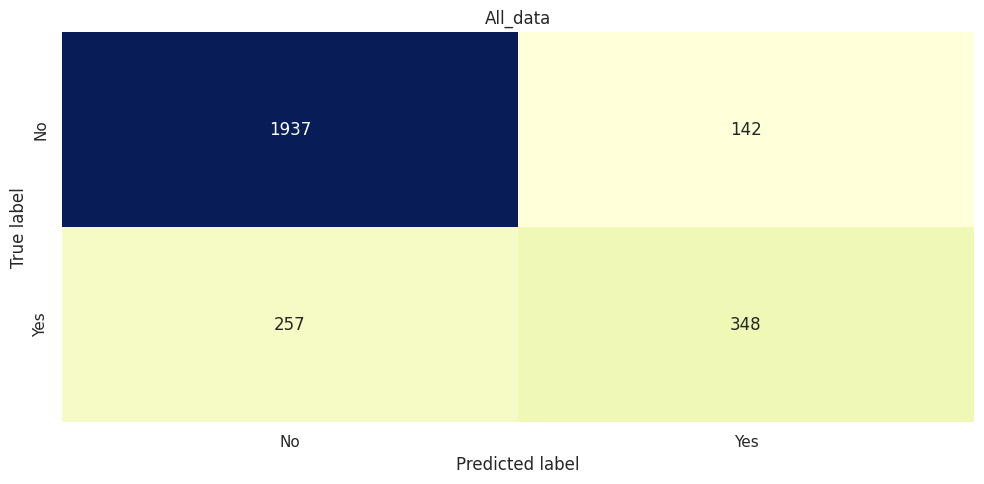

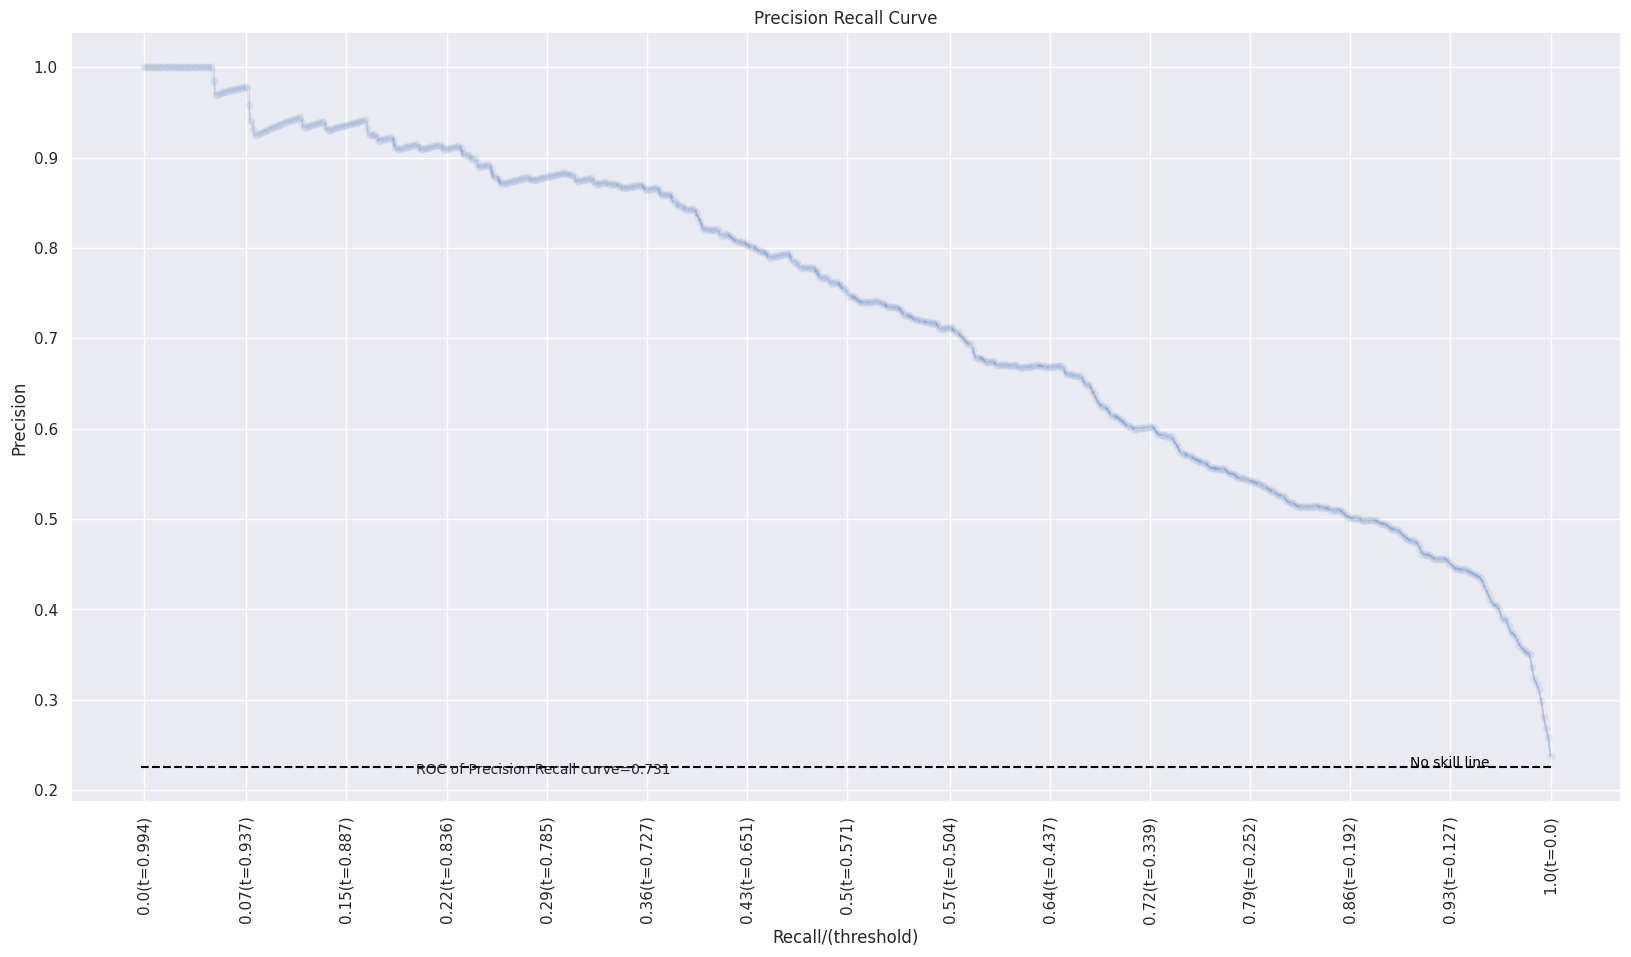

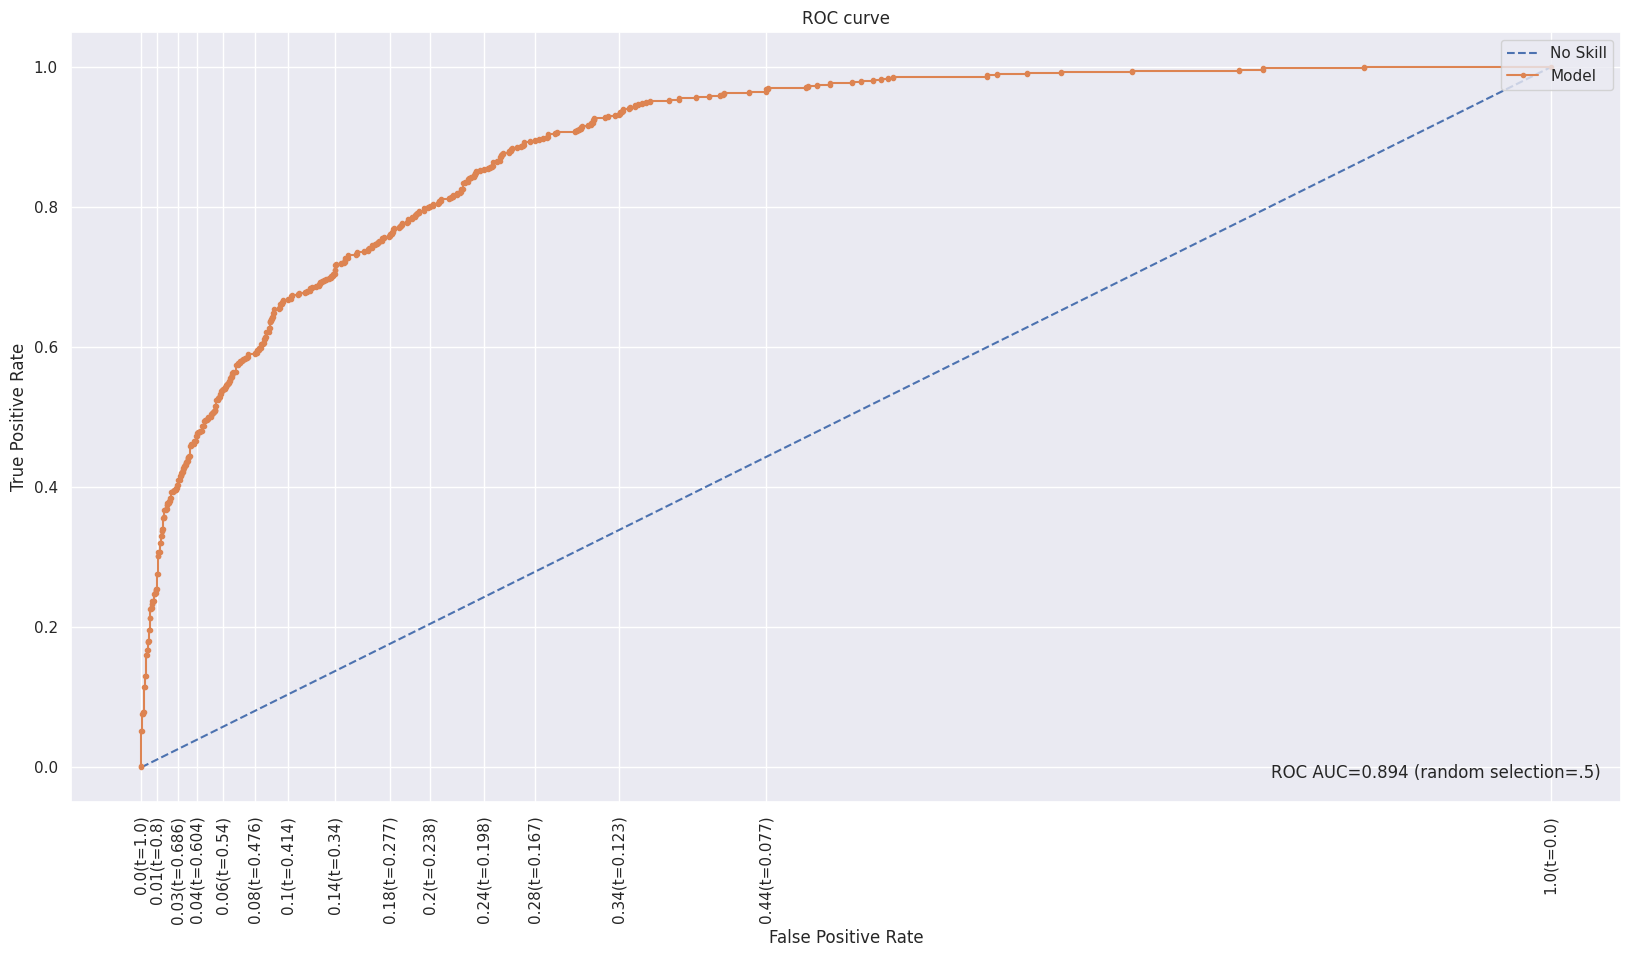

In [81]:
from importlib import reload
for file in files2Copy:
  shutil.copyfile(os.path.join('/content/drive/My Drive/Colab Notebooks/', file), os.path.join('/content', file))
import ml_funcs
reload(ml_funcs)

# model = PneumoniaModel.load_from_checkpoint(os.path.join(colab_weights, "weights_1.ckpt"))
# model.eval()
# model.to(device)

# preds = []
# labels = []

# with torch.no_grad():
#     for data, label in tqdm(val_dataset):
#         data = data.to(device).float().unsqueeze(0)
#         pred = torch.sigmoid(model(data)[0].cpu())
#         preds.append(pred)
#         labels.append(label)
# preds= torch.tensor(preds)
# labels = torch.tensor(labels).int()

scores_names=['recall' ,
              'precision',
              'accuracy',
              'auc_weighted',
              # 'balanced_accuracy',
              # 'roc_auc',
              # 'aucpr',

              'f1',
              'kappa',
              'mcc',
              ]
y_model=pd.DataFrame([labels.numpy(), [1 if i>=.5 else 0 for i in preds.numpy()], preds.numpy()], index=['y_true','y_pred','prob']).T
y_model['CV_Iteration']=1
uscores, confMats= ml_funcs.classifer_performance_batch(y_model,
                                            map_lbls={0:'No', 1:'Yes'},
                                            scores_names=scores_names)
print(uscores)
# fig, axis = plt.subplots(3, 3, figsize=(9, 9))
# for i in range(3):
#     for j in range(3):
#         rnd_idx = np.random.randint(0, len(preds))
#         axis[i][j].imshow(val_dataset[rnd_idx][0][0], cmap="bone")
#         axis[i][j].set_title(f"Pred:{int(preds[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}")
#         axis[i][j].axis("off")

# 4-Interpretability

Class Acvitation Maps (CAM) is to visualize the decision of the classifier (https://arxiv.org/abs/1512.04150). <br />

Class Activation Maps (CAM) are a visualization technique used in deep learning, particularly in the context of convolutional neural networks (CNNs), to identify which regions of an input image are most relevant for a specific class prediction. CAMs provide insights into what the network "sees" and why it makes certain predictions.

In [79]:
temp_model = torchvision.models.resnet18()
list(temp_model.children())[:-2]  # get all layers up to avgpool
torch.nn.Sequential(*list(temp_model.children())[:-2])

class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)

        # Extract the feature map
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])
    def forward(self, data):

        # Compute feature map
        feature_map = self.feature_map(data)
        # Use Adaptive Average Pooling as in the original model
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1, 1))
        # print(avg_pool_output.shape)
        # Flatten the output into a 512 element vector
        avg_pool_output_flattened = torch.flatten(avg_pool_output)
        # print(avg_pool_output_flattened.shape)
        # Compute prediction
        pred = self.model.fc(avg_pool_output_flattened)
        return pred, feature_map

def cam(model, img):
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    features = features.reshape((512, 49))
    weight_params = list(model.model.fc.parameters())[0]
    weight = weight_params[0].detach()


    cam = torch.matmul(weight, features)
    cam_img = cam.reshape(7, 7).cpu()
    return cam_img, torch.sigmoid(pred)

def visualize(img, cam, pred):
    img = img[0].cpu()
    cam = transforms.functional.resize(cam.unsqueeze(0), (224, 224))[0]

    fig, axis = plt.subplots(1, 2)
    axis[0].imshow(img, cmap="bone")
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(cam, alpha=0.5, cmap="jet")
    plt.title(pred>.5)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/migration/migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint data/weights/weights_3.ckpt`
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['feature_map.0.weight', 'feature_map.1.weight', 'feature_map.1.bias', 'feature_map.1.running_mean', 'feature_map.1.running_var', 'feature_map.4.0.conv1.

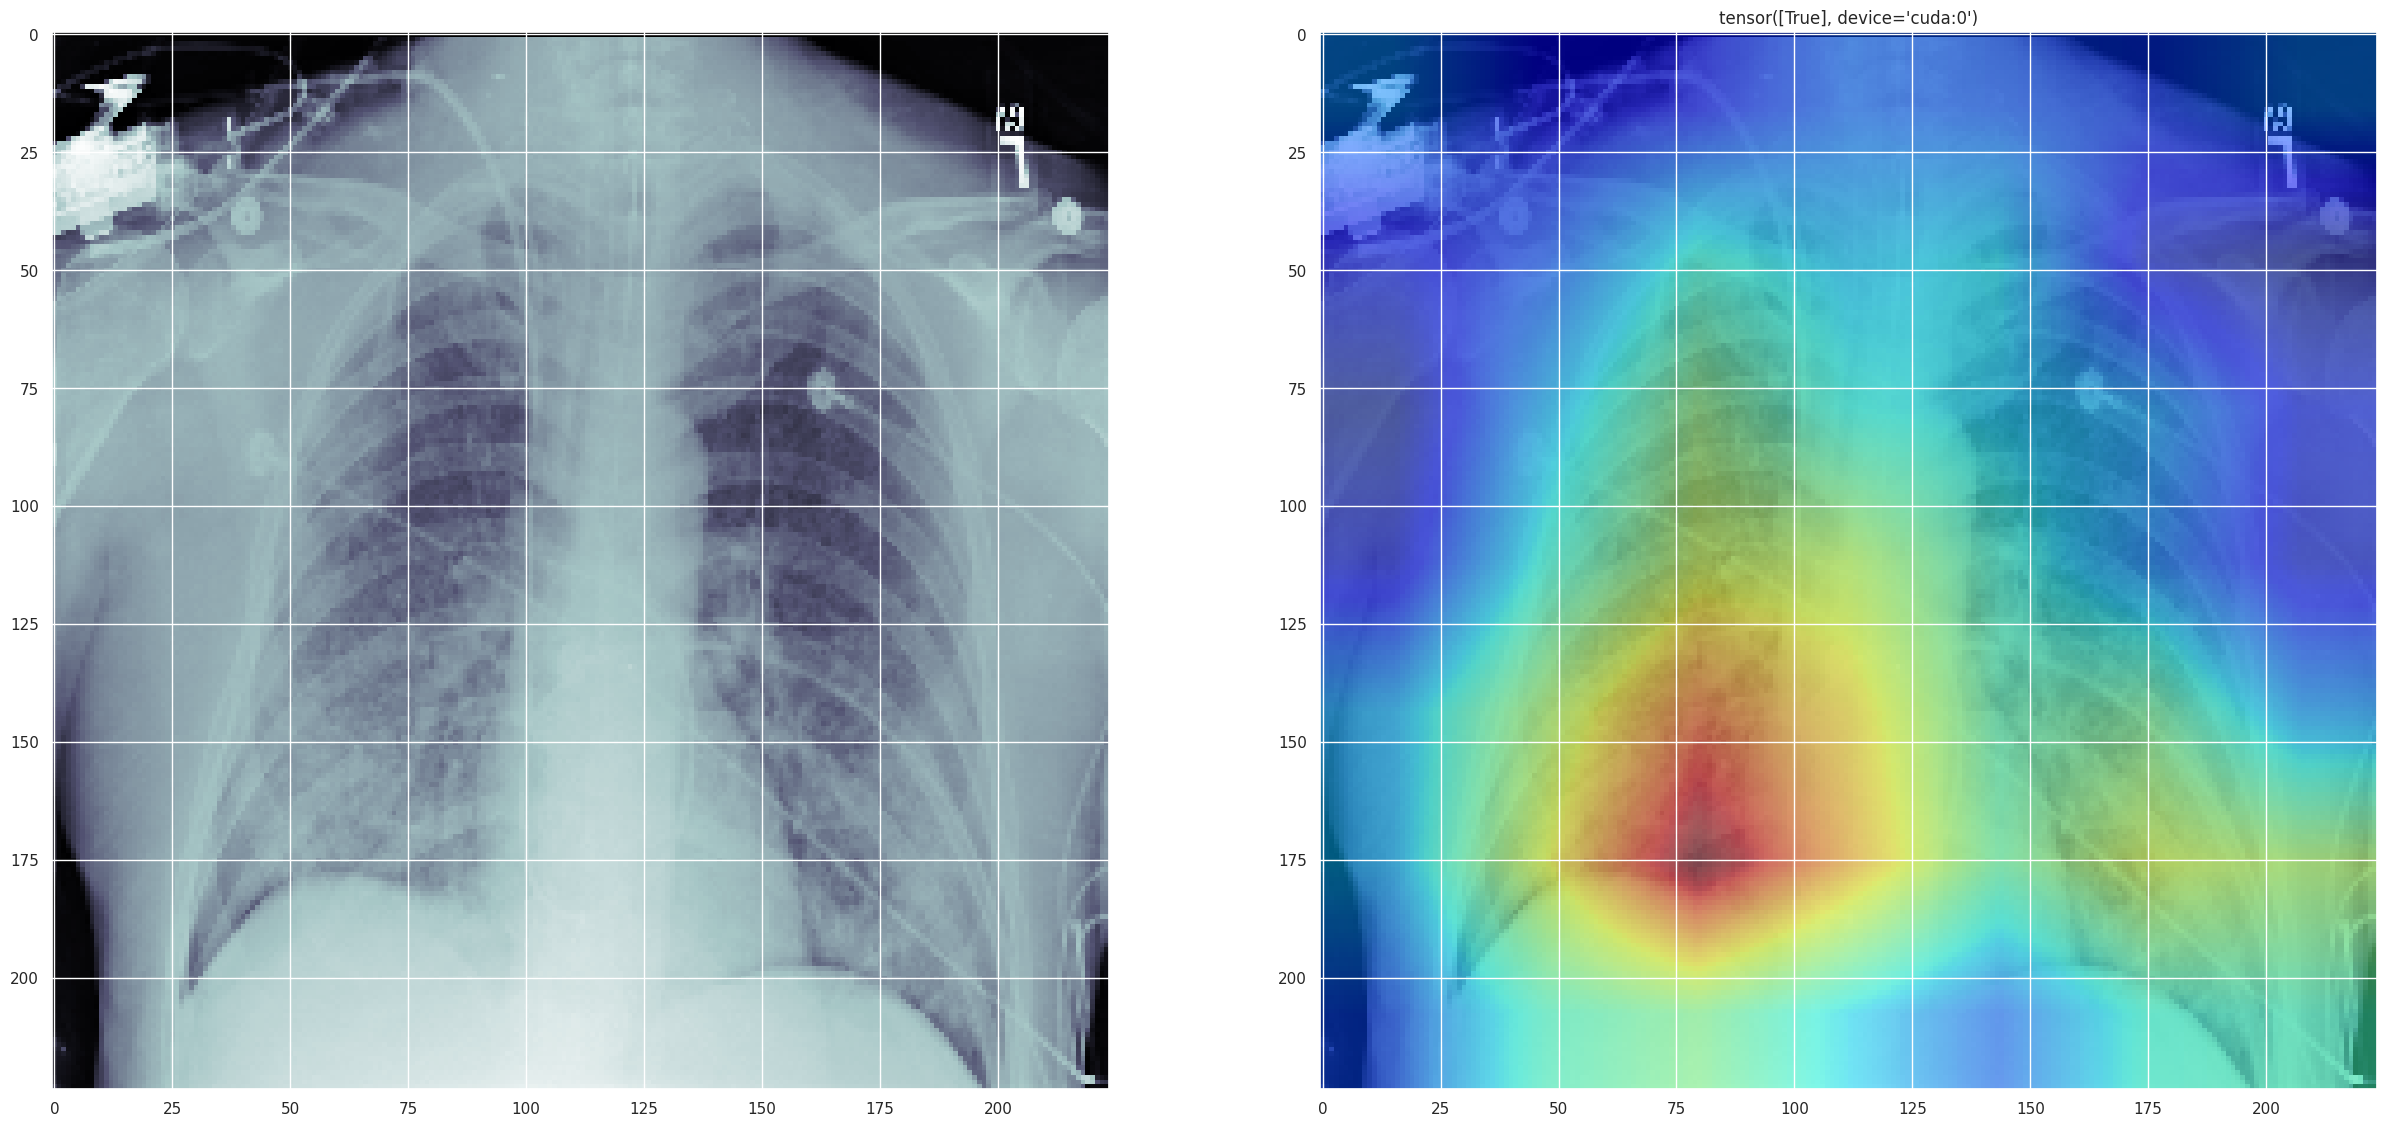

In [80]:
model = PneumoniaModel.load_from_checkpoint(os.path.join(colab_weights, "weights_3.ckpt"), strict=False)
model.eval()
model.to(device)

img = val_dataset[-6][0]
img = img.to(device)
activation_map, pred = cam(model, img)  # Compute the Class activation map given the subject

visualize(img, activation_map, pred)